
# Rossmann Sales Forecasting Using AML Forecasting Toolkit

## Summary
This notebook demonstrates how to use the Azure Machine Learning (AML) Forecasting Toolkit (FTK) to forecast store sales on the [Kaggle Rossmann sales dataset](https://www.kaggle.com/c/rossmann-store-sales/data). The following model development and deployment steps are implemented
* Data Ingestion: Load the Rossmann dataset as TimeSeriesDataFrame, a time series data structure provided by the FTK.
* Feature Engineering
    * Rolling window features
    * Lag features
* Model Training and Selection: Compare the performance of naive, seasonal naive, and ARIMA, and choose the one with the best performance. 
* Model Deployment: Deploy the model pipeline via Azure Machine Learning Workbench to be consumed as a web service.

**Note**:   
The notebook takes about two hours to run if run_quick is set to False and run on all 1115 stores. Set run_quick to True for a quick walk-through.   

## Prerequisites
To use the deployment feature, you need to run this notebook within Azure Machine Learning Workbench. We will support deployment outside of Azure Machine Learning Workbench soon.    
For data processing and model development only, you can run the notebook outside of Azure Machine Learning Workbench.   

Follow the instructions below to install the FTK in AML Workbench and get prepared for deployment. 
1. Create an Azure Machine Learning Experimentation account, install AML Workbench, and create an AML project following [this documentation](https://docs.microsoft.com/en-us/azure/machine-learning/preview/quickstart-installation). 
2. Install Docker if you haven't. If you run into any hyper-v related issues on Windows, see [this link](https://blogs.technet.microsoft.com/canitpro/2015/09/08/step-by-step-enabling-hyper-v-for-use-on-windows-10/).
3. If you don't have kubectl.exe on your computer, download it from [here](https://storage.googleapis.com/kubernetes-release/release/v1.9.2/bin/windows/amd64/kubectl.exe) and put it under a directory that's in the system Path, e.g. C:\users\willsmith\bin\.
4. Start AML Workbench as Administrator. Open an existing project or create a new one.
5. In the toolbar, click File -> Open Command Prompt
6. Follow the environment setup instructions from our [dogfood page](https://microsoft.sharepoint.com/teams/forecastpackagedogfood/SitePages/Home.aspx).
7. To open a jupyter notebook, run ```az ml notebook start``` from the AML command prompt to open the notebook in a browser. Make sure your ftk conda environment is activated before launching the notebook. 

## Import Packages

In [1]:
import sys
sys.executable

'C:\\Users\\sethmott\\AppData\\Local\\Continuum\\Anaconda3\\envs\\azuremlftk_mar2018\\python.exe'

In [2]:
import sys
import pandas as pd
import numpy as np

from ftk.data.rossmann.load_rossmann_data import load_rossmann_dataset

from ftk.dataframets import TimeSeriesDataFrame
from ftk.dataframeforecast import ForecastDataFrame
from ftk.pipeline import AzureMLForecastPipeline

from ftk.transforms.lagoperator import LagOperator
from ftk.transforms.rollingwindow import RollingWindow
from ftk.transforms.tsimputer import TimeSeriesImputer

from ftk.models.arima import Arima
from ftk.models.naive import SeasonalNaive, Naive

from ftk.operationalization.scorecontext import ScoreContext
from ftk.operationalization.deployment import AMLEnvironment, AMLDeployment

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\dataframets.py:41: UserWarning: Unable to import .NET time series utilities. SeasonalityDetector and ExponentialSmoothingModel not available.
  + 'SeasonalityDetector and ExponentialSmoothingModel not available.')
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\models\recursiveforecaster.py:27: UserWarning: Unable to import .NET time series utilities. SeasonalityDetector and ExponentialSmoothingModel not available.
  + 'SeasonalityDetector and ExponentialSmoothingModel not available.')


## Load Data

In [5]:
train_ts, test_ts = load_rossmann_dataset()

# Sort the data by store and date
train_ts.sort_index(level=[train_ts.grain_colnames, train_ts.time_colname], inplace=True)
test_ts.sort_index(level=[test_ts.grain_colnames, test_ts.time_colname], inplace=True)

# Select a small sample of data to speed up model tunning. Optional
run_quick = True
if run_quick:
    train_ts = train_ts.loc[train_ts.grain_index.isin([1,2,3,4,5,13])]
    test_ts = test_ts.loc[test_ts.grain_index.isin([1,2,3,4,5,13])]

In [17]:
train_ts

,,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,Store,,,,,,,
2013-01-01,1,2,0.00,0,0,0,a,1
2013-01-02,1,3,5530.00,668,1,0,0,1
2013-01-03,1,4,4327.00,578,1,0,0,1
2013-01-04,1,5,4486.00,619,1,0,0,1
2013-01-05,1,6,4997.00,635,1,0,0,1
2013-01-06,1,7,0.00,0,0,0,0,1
2013-01-07,1,1,7176.00,785,1,1,0,1
2013-01-08,1,2,5580.00,654,1,1,0,1
2013-01-09,1,3,5471.00,626,1,1,0,1


## Initial Data Exploration
The ```TimeSeriesDataFrame.ts_report()``` function generates a comprehensive report of the time series data, including both general data description and statistics specific to time series data. 

------------------------------------------  Data Overview  -------------------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 5468 entries, (2013-01-01 00:00:00, 1) to (2015-07-31 00:00:00, 13)
Data columns (total 7 columns):
DayOfWeek        5468 non-null int64
Sales            5468 non-null float64
Customers        5468 non-null int64
Open             5468 non-null int64
Promo            5468 non-null int64
StateHoliday     5468 non-null object
SchoolHoliday    5468 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 536.6+ KB
------------------------------------  Numerical Variable Summary  ------------------------------------
       DayOfWeek    Sales  Customers    Open   Promo  SchoolHoliday
count    5468.00  5468.00    5468.00 5468.00 5468.00        5468.00
mean        4.00  4999.06     580.70    0.83    0.38           0.18
std         2.00  3228.71     406.00    0.38    0.49           0.39
min         1.00     0.00       0.00  

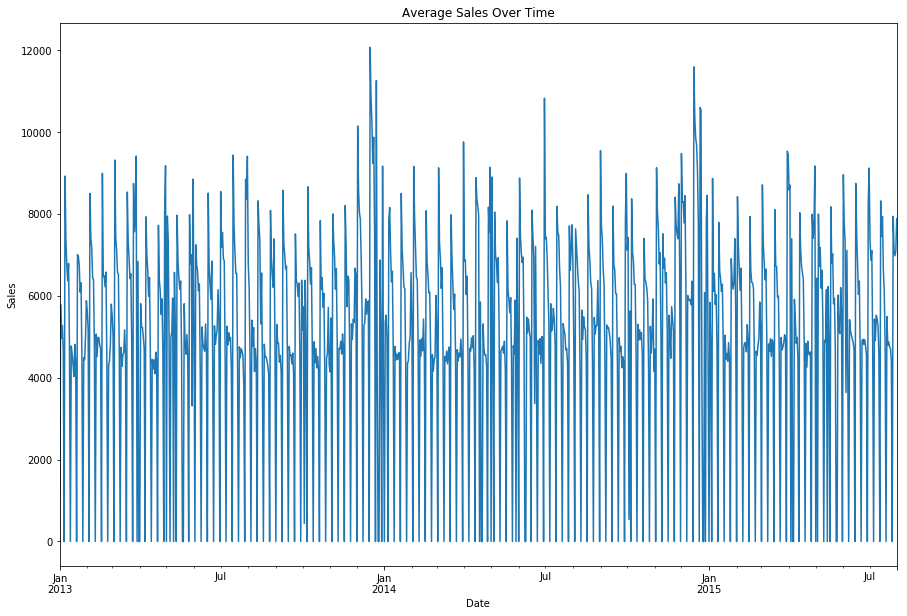

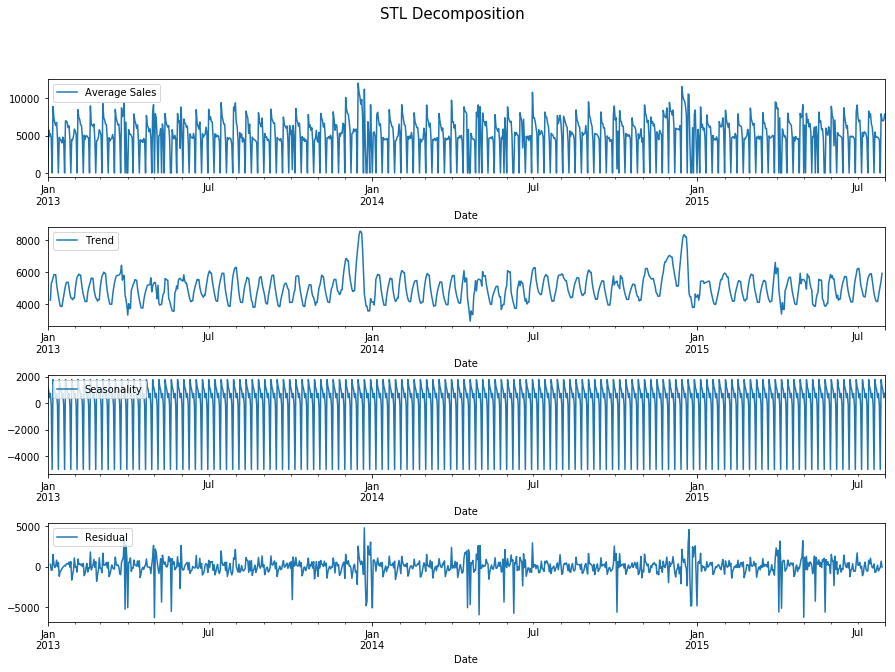

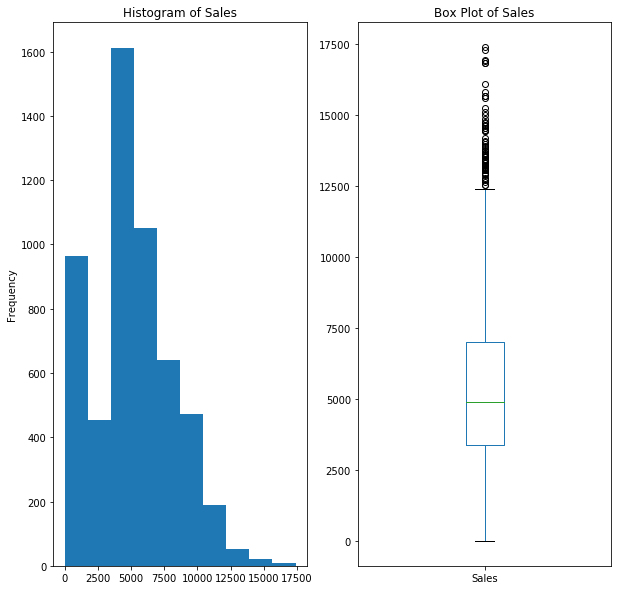

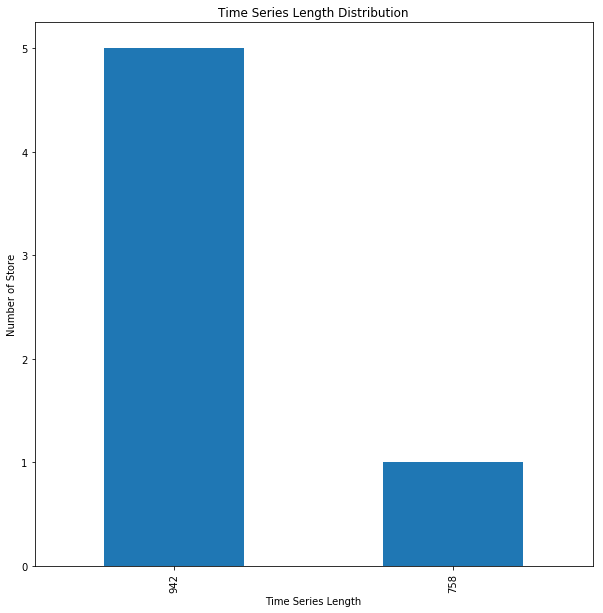

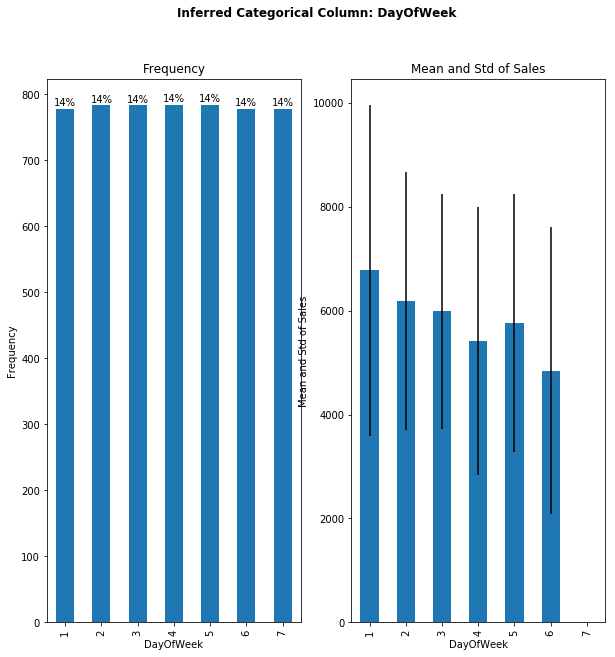

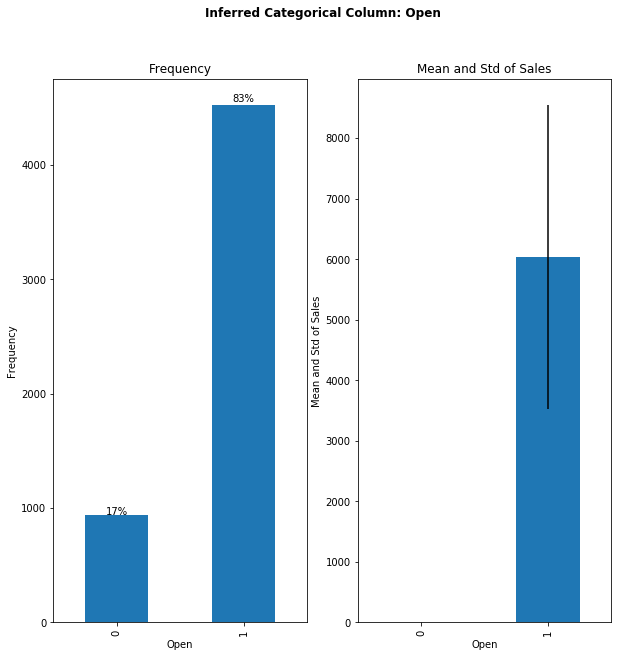

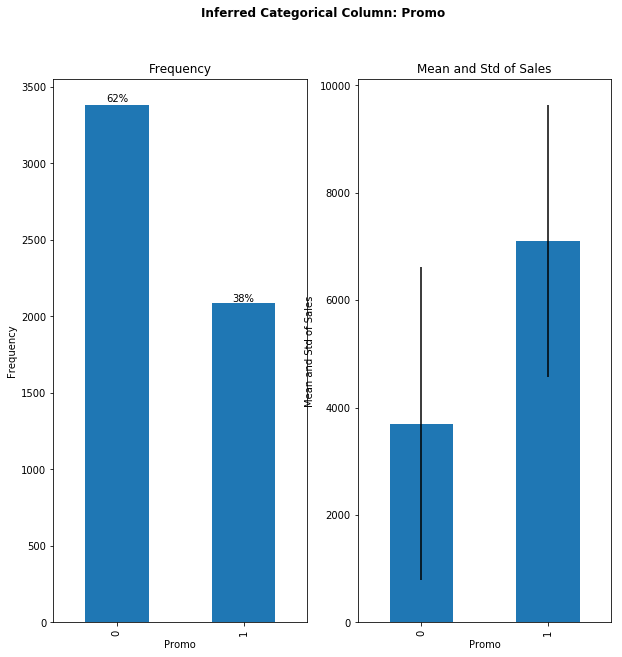

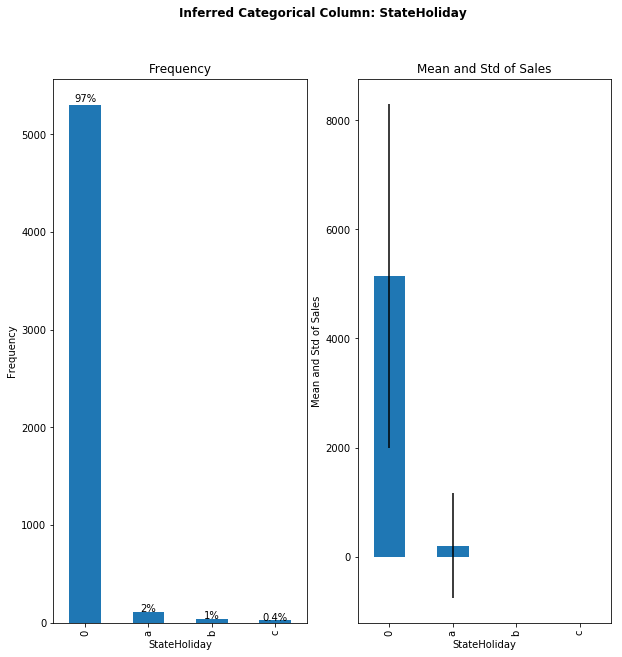

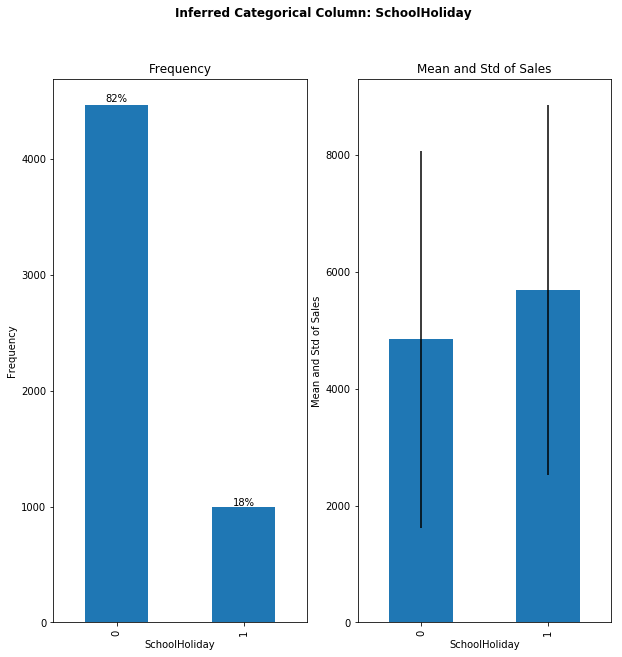

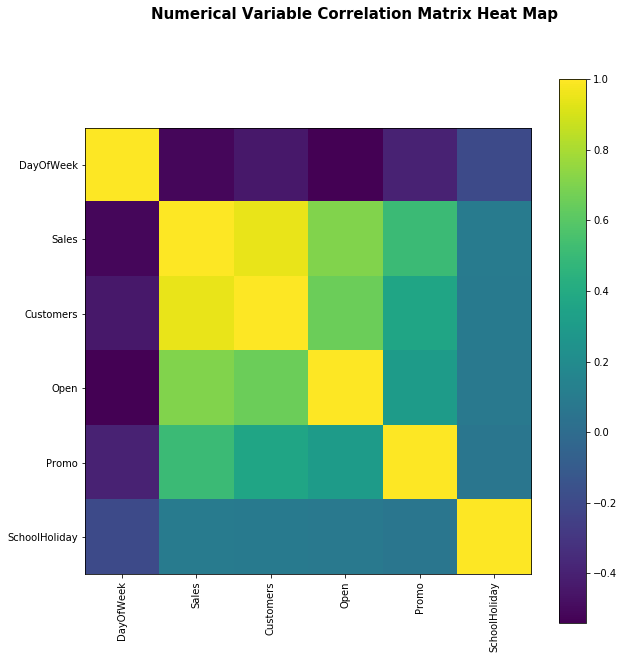

In [7]:
%matplotlib inline
train_ts.ts_report()

### Data Preparation - Impute missing data
From the time series report above, we found that the frequency of 1 store (180 stores, if the whole dataset is used) cannot be inferred. This is usually caused by irregular datetime gaps. We will use the TimeSeriesImputer transformer to fix this.


First, We call the ```get_frequency_dict()``` method to check which stores have irregular datetime gaps

In [5]:
frequency_dict = train_ts.get_frequency_dict()
frequency_dict

{'D': [1, 2, 3, 4, 5], 'None': [13]}

We pick one of the stores without inferred frequency for further examination. 

------------------------------------------  Data Overview  -------------------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 758 entries, (2013-01-01 00:00:00, 13) to (2015-07-31 00:00:00, 13)
Data columns (total 7 columns):
DayOfWeek        758 non-null int64
Sales            758 non-null float64
Customers        758 non-null int64
Open             758 non-null int64
Promo            758 non-null int64
StateHoliday     758 non-null object
SchoolHoliday    758 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 120.6+ KB
------------------------------------  Numerical Variable Summary  ------------------------------------
       DayOfWeek    Sales  Customers   Open  Promo  SchoolHoliday
count     758.00   758.00     758.00 758.00 758.00         758.00
mean        4.00  4124.77     313.64   0.82   0.38           0.16
std         2.00  2429.24     167.60   0.39   0.49           0.37
min         1.00     0.00       0.00   0.00   0.00   

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\dataframets.py:1479: UserWarning: STL decomposition failed due to ValueError: You must specify a freq or x must be a pandas object with a timeseries index witha freq not set to None
  warn('STL decomposition failed due to ValueError: {0}'.format(err))


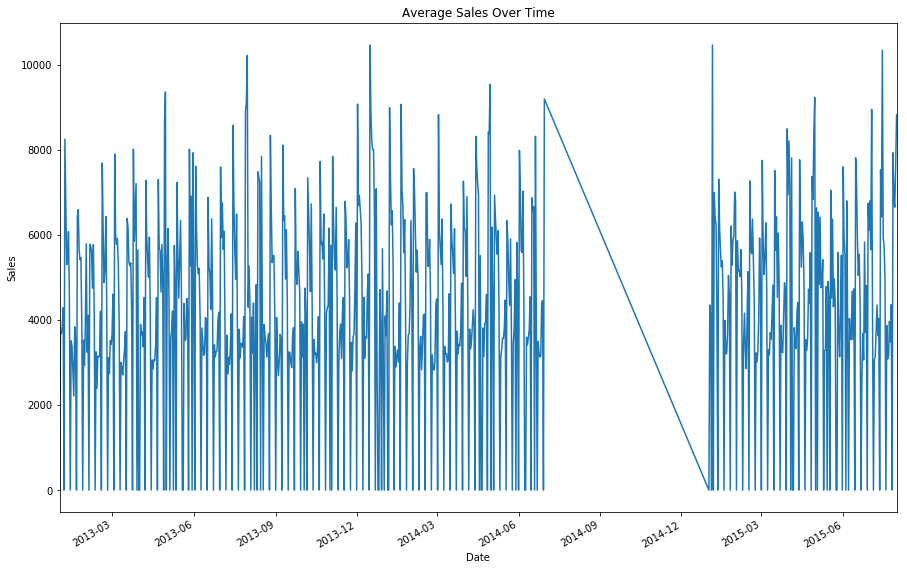

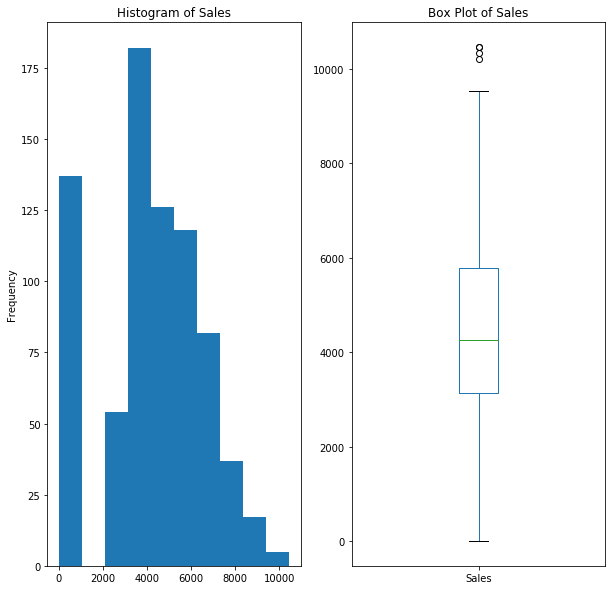

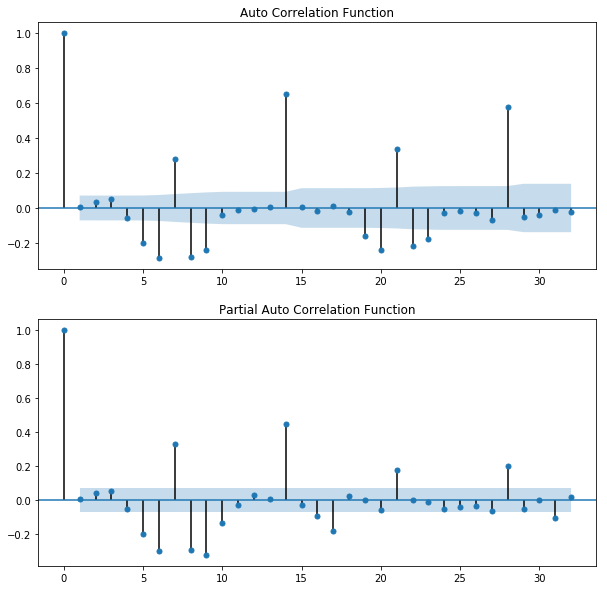

In [6]:
train_ts_13 = train_ts.loc[train_ts.grain_index==13]
train_ts_13.ts_summary()

We found store 13 has half a year of missing data from 2014-07-01 to 2014-12-31. It turned out this is the case for all 180 stores for which the frequency can not be inferred. 

There is no easy way to fix this in reality. For the purpose of generating predictions for the competition, we fill this gap  an imputation transform that is equivalent to a naive forecast on the missing dates.


In [26]:
?TimeSeriesImputer

In [18]:
# Use a TimeSeriesImputer to forward fill values at missing days
imputer = TimeSeriesImputer(input_column='Sales', 
                            option='fillna',
                            method='ffill',
                            freq='D')

imputed_ts = imputer.transform(train_ts)

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\ftk\dataframets.py:829: UserWarning: Failed to infer a frequency for 1 of the time series
  UserWarning)


Now, all time series are regular with a daily frequency:

In [19]:
imputed_ts.get_frequency_dict()

{'D': [1, 2, 3, 4, 5, 13]}

------------------------------------------  Data Overview  -------------------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 5652 entries, (2013-01-01 00:00:00, 1) to (2015-07-31 00:00:00, 13)
Data columns (total 7 columns):
DayOfWeek        5468 non-null float64
Sales            5652 non-null float64
Customers        5468 non-null float64
Open             5468 non-null float64
Promo            5468 non-null float64
StateHoliday     5468 non-null object
SchoolHoliday    5468 non-null float64
dtypes: float64(6), object(1)
memory usage: 533.2+ KB
------------------------------------  Numerical Variable Summary  ------------------------------------
       DayOfWeek    Sales  Customers    Open   Promo  SchoolHoliday
count    5468.00  5652.00    5468.00 5468.00 5468.00        5468.00
mean        4.00  5135.56     580.70    0.83    0.38           0.18
std         2.00  3261.74     406.00    0.38    0.49           0.39
min         1.00     0.00       0.00  

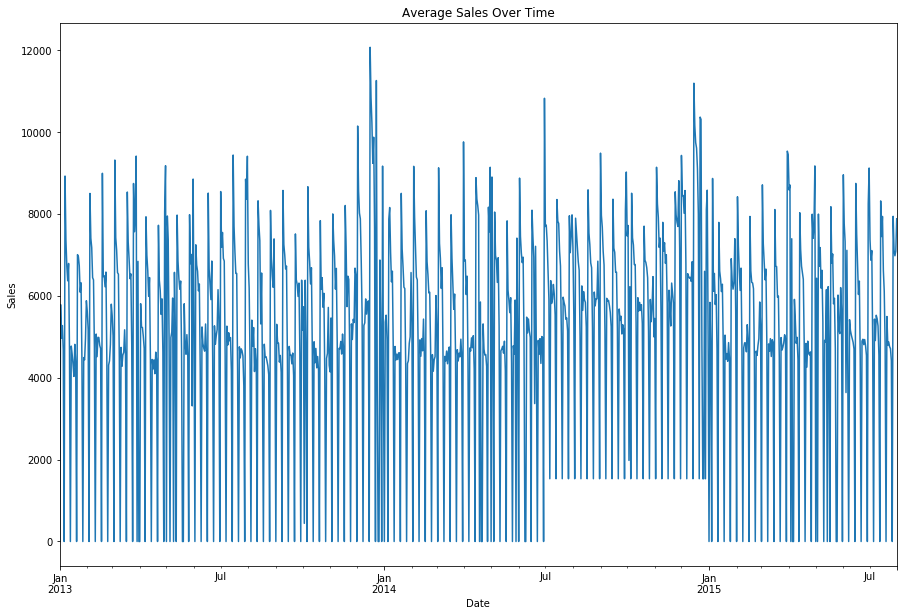

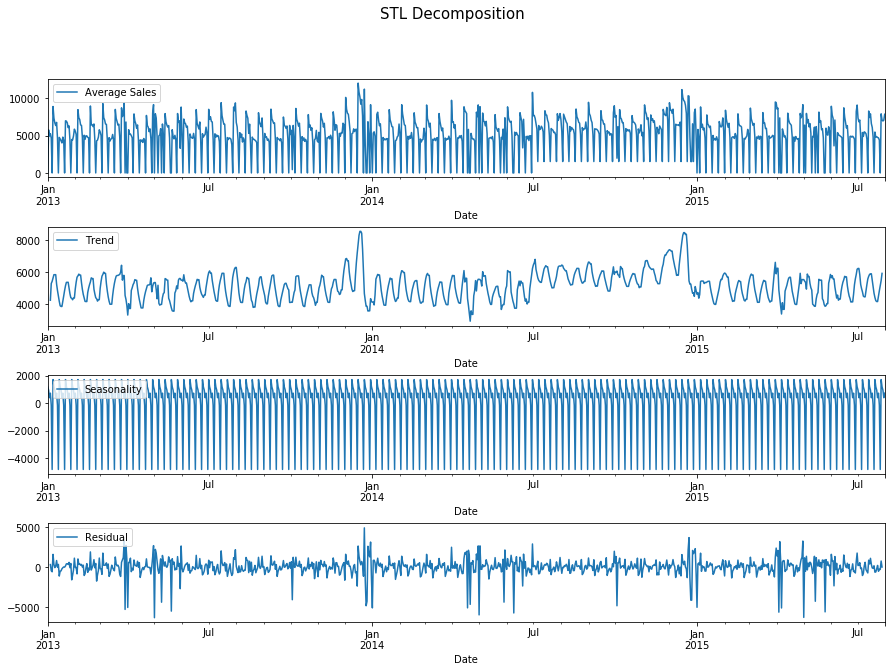

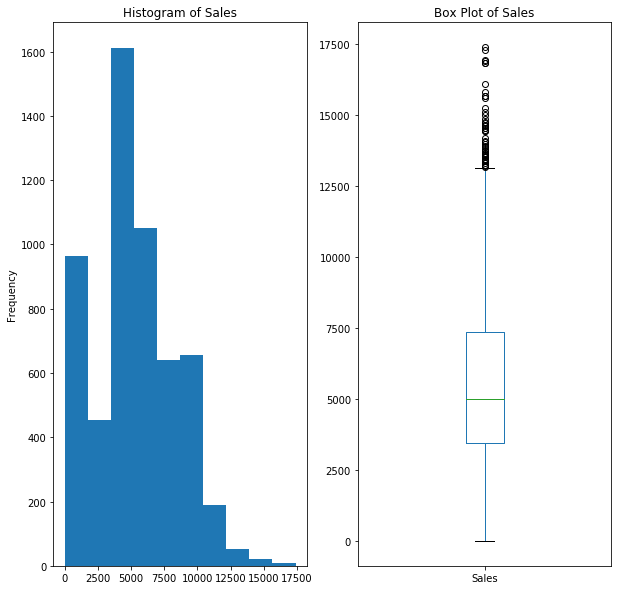

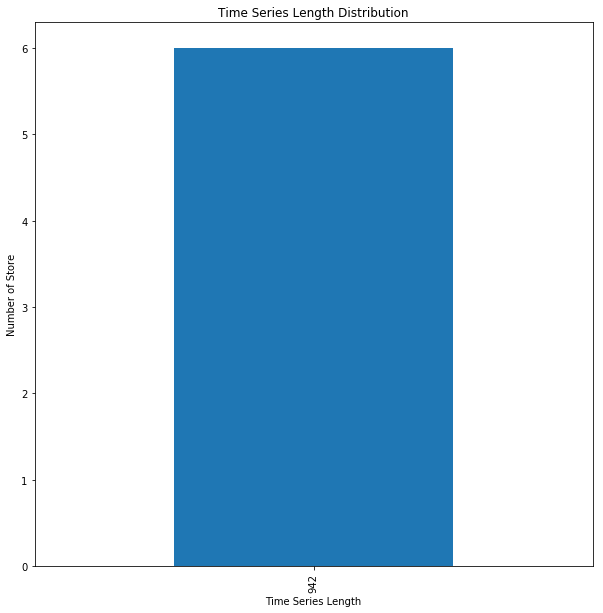

In [20]:
imputed_ts.ts_summary()

## Feature Engineering

### Create and Test Data Transformers
**Note**: Currently, we only use univariate time series models. Therefore, the transfomers are created and tested for
demonstration purpose only. 

In [9]:
# Create transformers
rolling_transformer = RollingWindow(window_size=3, transform_dict={'mean': ['Sales', 'Customers']})
lag_transformer = LagOperator(lags_to_construct=3, columns_to_lag='Sales')

# check transformer output
transformed_ts = rolling_transformer.transform(imputed_ts)
transformed_ts = lag_transformer.transform(transformed_ts)
transformed_ts.head(30)

DayOfWeek    Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                            
2013-01-01 1           2.00     0.00       0.00  0.00   0.00            a   
           2           2.00     0.00       0.00  0.00   0.00            a   
           3           2.00     0.00       0.00  0.00   0.00            a   
           4           2.00     0.00       0.00  0.00   0.00            a   
           5           2.00     0.00       0.00  0.00   0.00            a   
           13          2.00     0.00       0.00  0.00   0.00            a   
2013-01-02 1           3.00  5530.00     668.00  1.00   0.00            0   
           2           3.00  4422.00     650.00  1.00   0.00            0   
           3           3.00  6823.00     805.00  1.00   0.00            0   
           4           3.00  9941.00    1429.00  1.00   0.00            0   
           5           3.00  4253.00     577.00  1.00   0.00            0   
           13          3.00  3737.00     317.00  1.00   0.00            0   
2013-01-03 1           4.00  4327.00     578.00  1.00   0.00            0   
           2           4.00  4159.00     555.00  1.00   0.00            0   
           3           4.00  5902.00     721.00  1.00   0.00            0   
           4           4.00  8247.00    1248.00  1.00   0.00            0   
           5           4.00  3465.00     491.00  1.00   0.00            0   
           13          4.00  3674.00     292.00  1.00   0.00            0   
2013-01-04 1           5.00  4486.00     619.00  1.00   0.00            0   
           2           5.00  4484.00     574.00  1.00   0.00            0   
           3           5.00  6069.00     690.00  1.00   0.00            0   
           4           5.00  8290.00    1232.00  1.00   0.00            0   
           5           5.00  4456.00     533.00  1.00   0.00            0   
           13          5.00  3848.00     340.00  1.00   0.00            0   
2013-01-05 1           6.00  4997.00     635.00  1.00   0.00            0   
           2           6.00  2342.00     324.00  1.00   0.00            0   
           3           6.00  4523.00     525.00  1.00   0.00            0   
           4           6.00 10338.00    1514.00  1.00   0.00            0   
           5           6.00  1590.00     202.00  1.00   0.00            0   
           13          6.00  4285.00     344.00  1.00   0.00            0   

                  SchoolHoliday  Customers_mean_window3  Sales_mean_window3  \
Date       Store                                                              
2013-01-01 1               1.00                     nan                 nan   
           2               1.00                     nan                 nan   
           3               1.00                     nan                 nan   
           4               1.00                     nan                 nan   
           5               1.00                     nan                 nan   
           13              1.00                     nan                 nan   
2013-01-02 1               1.00                     nan                 nan   
           2               1.00                     nan                 nan   
           3               1.00                     nan                 nan   
           4               1.00                     nan                 nan   
           5               1.00                     nan                 nan   
           13              1.00                     nan                 nan   
2013-01-03 1               1.00                  415.33             3285.67   
           2               1.00                  401.67             2860.33   
           3               1.00                  508.67             4241.67   
           4               1.00                  892.33             6062.67   
           5               0.00                  356.00             2572.67   
           13              1.00                  203

## Model Training and Validation
Split training data into train and validate datasets

In [10]:
validate_ts = imputed_ts.loc[imputed_ts.time_index >= '2015-06-14']
train_ts = imputed_ts.loc[imputed_ts.time_index < '2015-06-14']

### Initialize Models

Based on the inferred frequency and seasonality, we set the following model parameters. 

In [11]:
# Model parameters
rossmann_series_freq = 'D'
rossmann_series_seasonality = 7

In [12]:
# Initialize naive model
naive_model = Naive(freq=rossmann_series_freq)

# Initialize seasonal naive model
seasonal_naive_model = SeasonalNaive(freq=rossmann_series_freq, 
                                     seasonality=rossmann_series_seasonality)

# Initialize ARIMA(p,d,q) model
arima_order = [2,1,0]
arima_model = Arima(rossmann_series_freq, arima_order)

### Build the Pipelines

In [13]:
pipeline_naive = AzureMLForecastPipeline([('naive_model', naive_model)])
pipeline_seasonal_naive = AzureMLForecastPipeline([('seasonal_naive_model', seasonal_naive_model)])
pipeline_arima = AzureMLForecastPipeline([('arima_model', arima_model)])

### Fit the Pipelines

In [14]:
pipeline_naive = pipeline_naive.fit(train_ts)
pipeline_seasonal_naive = pipeline_seasonal_naive.fit(train_ts)
pipeline_arima = pipeline_arima.fit(train_ts)

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


### Predict and Evaluate Model Performances

In [15]:
validate_predicted_naive = pipeline_naive.predict(validate_ts)
validate_predicted_seasonal_naive = pipeline_seasonal_naive.predict(validate_ts)
validate_predicted_arima = pipeline_arima.predict(validate_ts)

validate_error_naive = validate_predicted_naive.calc_error()
validate_error_seasonal_naive = validate_predicted_seasonal_naive.calc_error()
validate_error_arima = validate_predicted_arima.calc_error()

print('Naive model MAPE: {0}'.format(validate_error_naive))
print('Seasonal naive model MAPE: {0}'.format(validate_error_seasonal_naive))
print('ARIMA model MAPE: {0}'.format(validate_error_arima))

C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Naive model MAPE: 30.35786605239013
Seasonal naive model MAPE: 19.38443606557351
ARIMA model MAPE: 26.673527712705365


The model evaluation results above show that the Seasonal Naive model outperforms the two three models. We will fit a Seasonal Naive model on all the training data and score the trained model on test data. 

In [16]:
pipeline_seasonal_naive.fit(pd.concat([train_ts, validate_ts]))
forecast_all_seasonal_naive = pipeline_seasonal_naive.predict(test_ts)
forecast_all_seasonal_naive.head(20)

,,Id,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,DistributionForecastSeasonalNaive,PointForecastSeasonalNaive
Date,Store,,,,,,,,
2015-08-01,1,40233,6,1.00,0,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,4364.00
2015-08-02,1,39377,7,0.00,0,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00
2015-08-03,1,38521,1,1.00,1,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,6102.00
2015-08-04,1,37665,2,1.00,1,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,5011.00
2015-08-05,1,36809,3,1.00,1,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,4782.00
2015-08-06,1,35953,4,1.00,1,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,5020.00
2015-08-07,1,35097,5,1.00,1,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,5263.00
2015-08-08,1,34241,6,1.00,0,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,4364.00
2015-08-09,1,33385,7,0.00,0,0,1,<scipy.stats._distn_infrastructure.rv_frozen o...,0.00


# Operationalization
In this section, we will deploy a pipeline as a Azure Machine Learning web service and use it for training and scoring. 
Currently, the following two workflows are available:
1. Deploy a pipeline that's not fitted as a web service. Call the web service to do both training and scoring.
2. Deploy a fitted pipeline. Call the web service to score only.

### Set model deployment parameters
Please change the following parameters to your own values. Make sure your AML environment, model management account, and resource group are located in the sam region. 

In [23]:
azure_subscription = '5be49961-ea44-42ec-8021-b728be90d58c'

# If cluster is True, create a Azure Container Service cluster and deploy the web service there.
# If False, deploy the "web service" locally.
# Cluste deployment takes about 20 minutes and local takes about 5 minutes. 
cluster = False

# The AML environment name. This could be an existing AML environment or a new AML environment to be created automatically.
aml_env_name = 'erwrightrossmann1'

# The resource group that contains the Azure resources related to the AML environment.
aml_env_resource_group = 'sethmottftktest'

# The location where the Azure resources related to the AML environment are located at.
aml_env_location = 'westcentralus'

# The AML model management account name. This could be an existing model management account a new model management 
# account to be created automatically. 
model_management_account_name = 'sethmottmlmm'

# The resource group that contains the Azure resources related to the model management account.
model_management_account_resource_group = 'sethmottbc'

# The location where the Azure resources related to the model management account are located at.
model_management_account_location = 'eastus2'

# The name of the deployment/web service.
deployment_name = 'sethmottftkserv'

# The directory to store deployment related files, such as pipeline pickle file, score script, and conda dependencies file. 
deployment_working_directory = 'C:\\Users\\sethmott\\ftk'

### Define the AML environment and deployment

In [24]:
aml_env = AMLEnvironment(env_name=aml_env_name, 
                         env_resource_group=aml_env_resource_group,
                         env_location=aml_env_location, 
                         azure_subscription=azure_subscription,
                         model_management_account_name=model_management_account_name, 
                         model_management_account_resource_group=model_management_account_resource_group,
                         model_management_account_location=model_management_account_location,
                         cluster=cluster)

snaive_model = SeasonalNaive(freq=rossmann_series_freq, seasonality=rossmann_series_seasonality)
pipeline_snaive = AzureMLForecastPipeline([('seasonal_naive_model', snaive_model)])
aml_deployment = AMLDeployment(aml_env=aml_env, 
                               deployment_name=deployment_name,
                               pipeline=pipeline_snaive,
                               deployment_working_directory=deployment_working_directory)

### Create the web service

In [25]:
# This step can take 5 to 20 minutes
# NOTE: Currently, recreate=False is not supported for deploying to ACS clusters
aml_deployment.deploy()

running az account set --subscription 5be49961-ea44-42ec-8021-b728be90d58c
running az ml account modelmanagement list


Exception: Failed to run command az ml account modelmanagement list with error ERROR: No module named 'azureml.api'
Traceback (most recent call last):
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\knack\cli.py", line 194, in invoke
    cmd_result = self.invocation.execute(args)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\azure\cli\core\commands\__init__.py", line 255, in execute
    self.commands_loader.load_arguments(command)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\azure\cli\core\__init__.py", line 201, in load_arguments
    self.command_table[command].load_arguments()  # this loads the arguments via reflection
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\azure\cli\core\commands\__init__.py", line 148, in load_arguments
    super(AzCliCommand, self).load_arguments()
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\knack\commands.py", line 76, in load_arguments
    cmd_args = self.arguments_loader()
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\azure\cli\core\__init__.py", line 353, in default_arguments_loader
    op = handler or self.get_op_handler(operation)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\site-packages\azure\cli\core\__init__.py", line 397, in get_op_handler
    op = import_module(mod_to_import)
  File "C:\Users\sethmott\AppData\Local\Continuum\Anaconda3\envs\azuremlftk_mar2018\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 985, in _gcd_import
  File "<frozen importlib._bootstrap>", line 968, in _find_and_load
  File "<frozen importlib._bootstrap>", line 957, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 673, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 697, in exec_module
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "C:\Users\sethmott\.azure\cliextensions\azure-cli-ml\azext_ml\model_management_account.py", line 20, in <module>
    from ._az_util import az_register_provider
  File "C:\Users\sethmott\.azure\cliextensions\azure-cli-ml\azext_ml\_az_util.py", line 25, in <module>
    from ._util import cli_context
  File "C:\Users\sethmott\.azure\cliextensions\azure-cli-ml\azext_ml\_util.py", line 49, in <module>
    from azureml.api.realtime.services import generate_main
ImportError: No module named 'azureml.api'


### Score and evaluate web service
To score a small dataset, use the score method to submit one web service call for all the data. 

In [30]:
# Need to add empty prediction columns to the validation data frame 
# and create a ForecastDataFram
validate_ts = validate_ts.assign(SeasonalNaivePointForecast=0.0,
                                 SeasonalNaiveDistributionForecast=np.nan)
validate_fcst = ForecastDataFrame(validate_ts, pred_point='SeasonalNaivePointForecast',
                                 pred_dist='SeasonalNaiveDistributionForecast')

# Define Score Context
# This is for deploying a pipeline not fitted yet.
score_context = ScoreContext(input_training_data_tsdf=train_ts, 
                             input_scoring_data_fcdf=validate_fcst, 
                             pipeline_execution_type='train_predict')

# If deploying a fitted pipeline use the following score_context
# score_context = ScoreContext(input_scoring_data_fcdf=input_scoring_data_df, 
#                             pipeline_execution_type='predict_only') 

# Get deployed web service
aml_web_service = aml_deployment.get_deployment()

# Score the web service
results = aml_web_service.score(score_context=score_context)
print(type(results))
print(results)

# Evaluate result
webservice_error = results.calc_error()
print('Seasonal naive model MAPE:{0}'.format(webservice_error))

running az ml service list realtime
running az ml service show realtime --name erwrightrossmann3
{
  "Id": "erwrightrossmann3",
  "Image": "mlcrpacre3414886465b.azurecr.io/erwrightrossmann3:1",
  "Name": "erwrightrossmann3",
  "State": "running",
  "UpdatedAt": "2018-02-15T17:30:53.6081532Z"
}

running az ml service usage realtime --id erwrightrossmann3
Scoring URL:
    http://127.0.0.1:32773/score

Headers:
    Content-Type: application/json

Swagger URL:
    http://127.0.0.1:32773/swagger.json

Sample CLI command:
    Usage for cmd: az ml service run realtime -i erwrightrossmann3 -d !! YOUR DATA HERE !!
    Usage for powershell: az ml service run realtime -i erwrightrossmann3 --% -d !! YOUR DATA HERE !!

Sample CURL call:
    curl -X POST -H "Content-Type:application/json" --data !! YOUR DATA HERE !! http://127.0.0.1:32773/score

Get debug logs by calling:
    az ml service logs realtime -i erwrightrossmann3

Get STDOUT/STDERR or Request/Response logs in App Insights:
    https://ana

To score a large dataset, use the score_driver method to submit multiple web service calls, one for each unique value of
group_col. 

In [35]:
# Call the forecast service once for each store in the validation set
results = aml_web_service.score_driver(score_context=score_context, group_col='Store')

# Calculate the forecasting errors for store time series
webservice_fcst_errors = results.calc_error(by='Store')
webservice_fcst_errors

,Store,MAPE
0,1,14.87
1,2,20.39
2,3,18.46
3,4,17.15
4,5,18.15
5,13,27.28
